In [29]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = "AAPL"  # Example: Apple Inc.

# Fetch historical market data
ticker = yf.Ticker(ticker_symbol)
hist = ticker.history(period="5y")  # Data for the past 1 month
print(hist)
# Save data to CSV
csv_filename = f"{ticker_symbol}_data.csv"
hist.to_csv(csv_filename)

print(f"CSV file saved as: {csv_filename}")

                                 Open        High         Low       Close  \
Date                                                                        
2020-04-06 00:00:00-04:00   60.888167   63.851276   60.519297   63.695965   
2020-04-07 00:00:00-04:00   65.717481   65.935898   62.853871   62.958221   
2020-04-08 00:00:00-04:00   63.761493   64.885098   63.395052   64.569618   
2020-04-09 00:00:00-04:00   65.207845   65.540314   64.237129   65.035538   
2020-04-13 00:00:00-04:00   65.113215   66.421258   64.511368   66.312050   
...                               ...         ...         ...         ...   
2025-03-31 00:00:00-04:00  217.009995  225.619995  216.229996  222.130005   
2025-04-01 00:00:00-04:00  219.809998  223.679993  218.899994  223.190002   
2025-04-02 00:00:00-04:00  221.320007  225.190002  221.020004  223.889999   
2025-04-03 00:00:00-04:00  205.539993  207.490005  201.250000  203.190002   
2025-04-04 00:00:00-04:00  193.889999  199.880005  187.339996  188.380005   

In [27]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-05 04:00:00+00:00,168.792998,169.589241,168.156006,168.783051,42055200,0.0,0.0
2024-04-08 04:00:00+00:00,168.235632,168.404831,167.449351,167.658356,37425500,0.0,0.0
2024-04-09 04:00:00+00:00,167.907177,169.280696,167.558831,168.872620,42451200,0.0,0.0
2024-04-10 04:00:00+00:00,168.006696,168.295327,166.324636,166.991486,49709300,0.0,0.0
2024-04-11 04:00:00+00:00,167.548852,174.635401,167.369706,174.217361,91070300,0.0,0.0



Training and evaluating deep learning models...

Training LSTM...
LSTM - Epoch [1/2], Train Loss: 0.0367, Val Loss: 0.0506
LSTM - Epoch [2/2], Train Loss: 0.0241, Val Loss: 0.0485


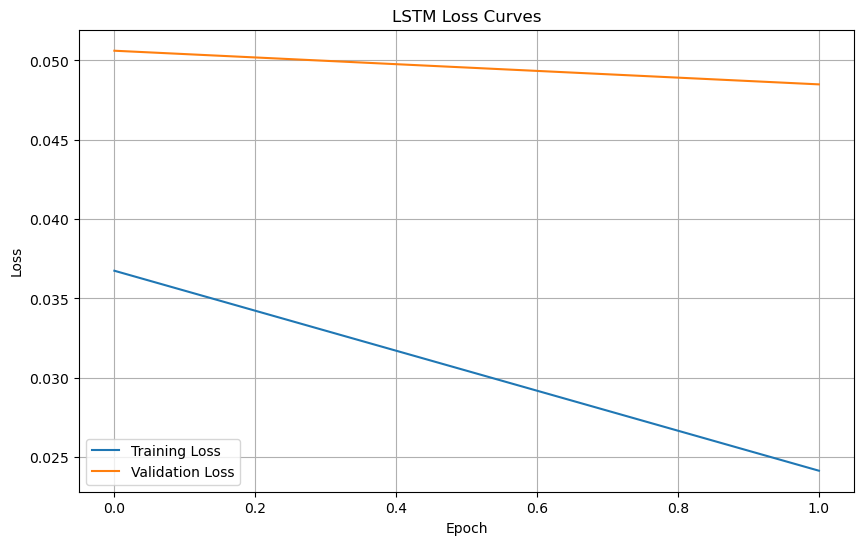

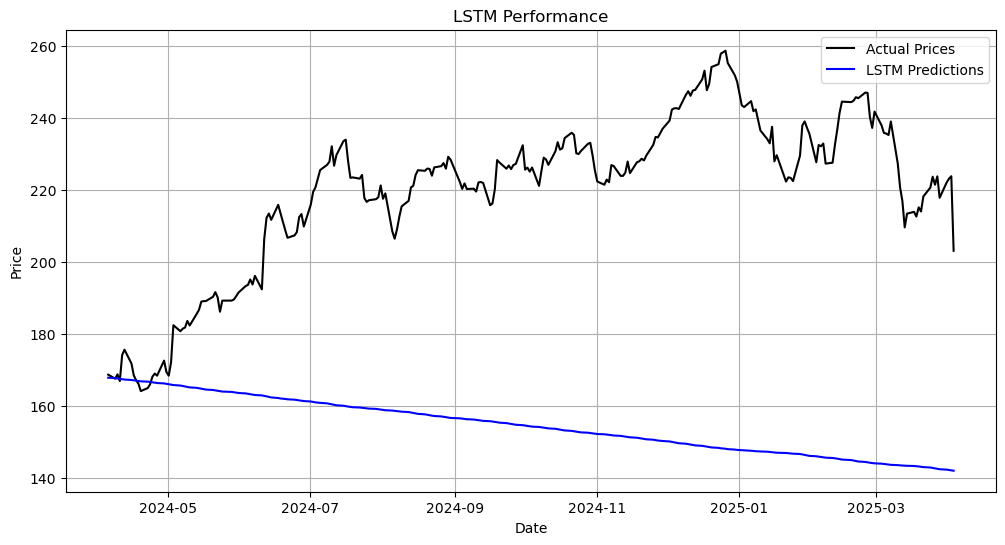


Training BiLSTM...
BiLSTM - Epoch [1/2], Train Loss: 0.0253, Val Loss: 0.0484
BiLSTM - Epoch [2/2], Train Loss: 0.0222, Val Loss: 0.0487


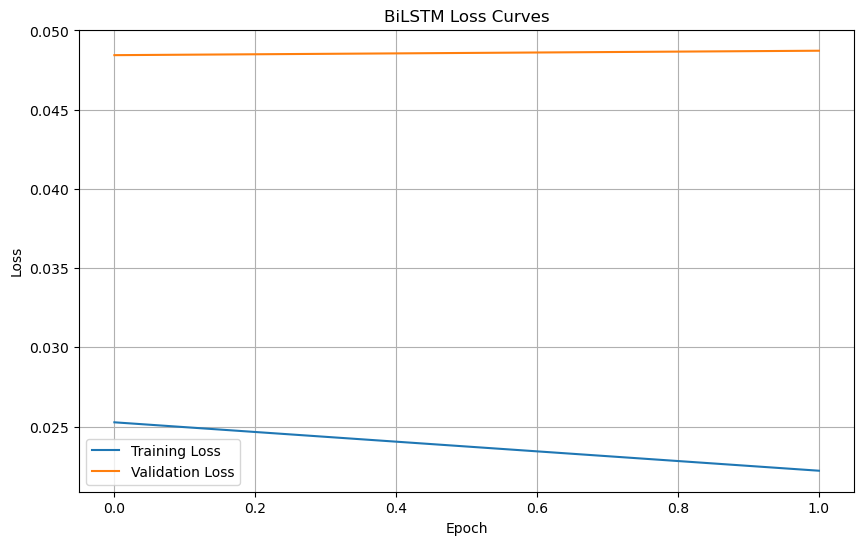

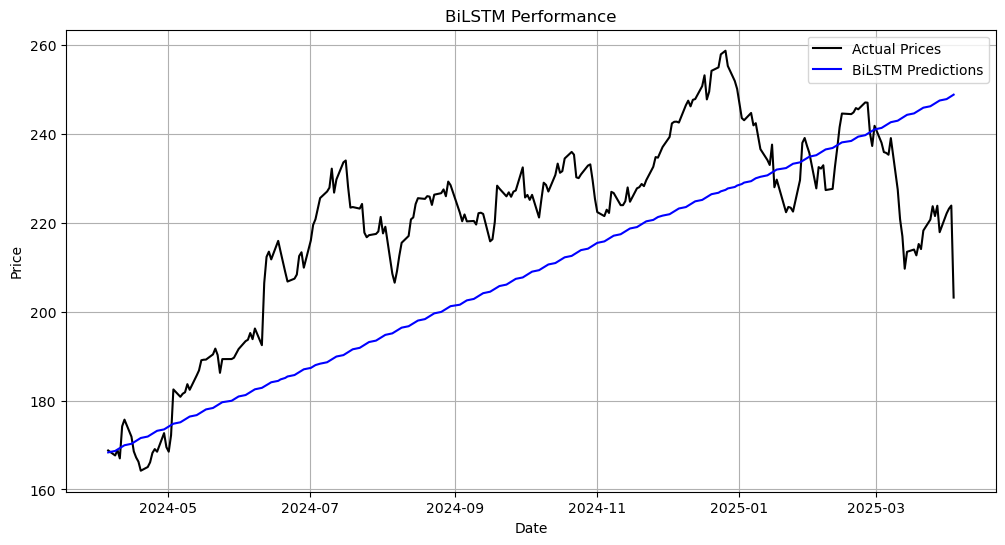


Training ABBA LSTM...
ABBA LSTM - Epoch [1/2], Train Loss: 0.0262, Val Loss: 0.0485


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

def load_and_preprocess_data(data_path):
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    return df

def create_stationary_data(prices):
    diff_prices = np.diff(prices, axis=0)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_diff = scaler.fit_transform(diff_prices)
    return scaled_diff, scaler

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Bidirectional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Attention-Based Bidirectional LSTM
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, lstm_output):
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

class ABBALSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(ABBALSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = AttentionLayer(hidden_size * 2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        lstm_output, _ = self.lstm(x, (h0, c0))
        attn_output = self.attention(lstm_output)
        out = self.dropout(attn_output)
        out = self.fc(out)
        return out

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

# Improvements to make predictions more realistic
def predict_with_dl_model(model, last_sequence, steps, scaler_diff, close_prices, device):
    model.eval()
    current_price = close_prices[-1][0]
    future_prices = [current_price]
    current_sequence = last_sequence.clone()
    
    # Calculate volatility for realistic price movements
    log_returns = np.diff(np.log(close_prices[-252:]), axis=0)  # Use recent year for volatility
    mu = np.mean(log_returns) * 252  
    sigma = np.std(log_returns) * np.sqrt(252)  
    daily_mu = mu / 252
    daily_sigma = sigma / np.sqrt(252)
    
    for _ in range(steps):
        with torch.no_grad():
            current_sequence_tensor = current_sequence.unsqueeze(0).to(device)
            pred_diff_scaled = model(current_sequence_tensor)
            pred_diff = scaler_diff.inverse_transform(pred_diff_scaled.cpu().numpy())[0][0]
            
            # Increase stochastic component weight
            dt = 1
            drift = (daily_mu - 0.5 * daily_sigma**2) * dt
            diffusion = daily_sigma * np.sqrt(dt) * np.random.normal(0, 1)
            stochastic_factor = np.exp(drift + diffusion)
            adjustment = current_price * (stochastic_factor - 1)
            
            # Reduce model weight, increase stochastic component
            blend_weight = 0.4  # Lower means more volatility
            blended_diff = (blend_weight * pred_diff) + ((1 - blend_weight) * adjustment)
            
            next_price = current_price + blended_diff
            next_price = max(0.01, next_price)
            
            future_prices.append(next_price)
            current_price = next_price
            
            # Update sequence for next prediction
            new_diff_scaled = torch.tensor([[pred_diff_scaled.item()]], dtype=torch.float32)
            current_sequence = torch.cat([current_sequence[1:], new_diff_scaled], dim=0)
    
    
    return np.array(future_prices[1:]).reshape(-1, 1)

def train_arima_model(train_data, order=(5,1,2)):
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        return model_fit
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
        return None

def train_sarima_model(train_data, order=(1,1,1), seasonal_order=(1,1,1,5)):
    try:
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        return model_fit
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None

def predict_with_statistical_model(model_fit, steps):
    try:
        forecast = model_fit.forecast(steps)
        return forecast.reshape(-1, 1)
    except Exception as e:
        print(f"Error forecasting with statistical model: {e}")
        return np.zeros((steps, 1))

def evaluate_dl_model(model, X_val, y_val, close_prices, seq_length, train_size, scaler_diff, device):
    model.eval()
    with torch.no_grad():
        val_pred_scaled = model(X_val.to(device)).cpu().numpy()
        val_pred_diff = scaler_diff.inverse_transform(val_pred_scaled)
        
        # Reconstruct prices from differences
        val_start_idx = seq_length + train_size
        val_reconstructed = [close_prices[val_start_idx-1][0]]
        
        for diff in val_pred_diff:
            next_price = val_reconstructed[-1] + diff[0]
            val_reconstructed.append(next_price)
        
        val_reconstructed = np.array(val_reconstructed[1:]).reshape(-1, 1)
        val_actual_prices = close_prices[val_start_idx:val_start_idx+len(val_pred_diff)]
    
    # Calculate metrics
    mape = np.mean(np.abs((val_actual_prices - val_reconstructed) / val_actual_prices)) * 100
    rmse = np.sqrt(np.mean((val_actual_prices - val_reconstructed) ** 2))
    
    return val_reconstructed, val_actual_prices, val_start_idx, mape, rmse

def evaluate_statistical_model(predictions, actual_prices):
    mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100
    rmse = np.sqrt(np.mean((actual_prices - predictions) ** 2))
    return mape, rmse

def plot_loss_curves(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_loss.png')
    plt.show()
    plt.close()

def plot_model_predictions(dates, actual_prices, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_prices, label='Actual Prices', color='black')
    plt.plot(dates, predictions, label=f'{model_name} Predictions', color='blue')
    plt.title(f'{model_name} Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_predictions.png')
    plt.show()
    
    plt.close()

def plot_all_model_predictions(df, results):
    plt.figure(figsize=(15, 8))
    
    # Plot actual data
    plt.plot(df.index[-200:], df['Close'].values[-200:], label='Actual', color='black', linewidth=2)
    
    # Plot each model's predictions
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i, (model_name, (dates, predictions, _, _)) in enumerate(results.items()):
        # Only plot the overlapping part of predictions and actual data
        overlap_size = min(len(dates), 200)
        plt.plot(dates[-overlap_size:], predictions[-overlap_size:], 
                 label=model_name, color=colors[i], alpha=0.7)
    
    plt.title('Model Comparison')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('all_models_comparison.png')
    plt.show()
    
    plt.close()

def plot_future_predictions(df, future_results):
    plt.figure(figsize=(15, 8))
    
    # Plot last 30 days of historical data
    plt.plot(df.index[-30:], df['Close'].values[-30:], label='Historical', color='black', linewidth=2)
    
    # Plot each model's future predictions
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i, (model_name, (future_dates, future_prices)) in enumerate(future_results.items()):
        # Show first 60 days of predictions
        future_days = min(60, len(future_dates))
        plt.plot(future_dates[:future_days], future_prices[:future_days], 
                 label=f'{model_name} Forecast', color=colors[i], alpha=0.7)
    
    plt.title('Future Price Predictions (60 Days)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('future_predictions.png')
    plt.show()
    
    plt.close()

def create_comparison_table(results):
    # Prepare data for the table
    model_names = []
    mapes = []
    rmses = []
    
    for model_name, (_, _, mape, rmse) in results.items():
        model_names.append(model_name)
        mapes.append(f"{mape:.2f}%")
        rmses.append(f"{rmse:.2f}")
    
    # Create a DataFrame for the table
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'MAPE': mapes,
        'RMSE': rmses
    })
    
    # Print and save the table
    print("\nModel Comparison:")
    print(comparison_df)
    comparison_df.to_csv('model_comparison.csv', index=False)
    
    # Also create a formatted text file
    with open('model_comparison.txt', 'w') as f:
        f.write("Model Comparison:\n")
        f.write("-" * 50 + "\n")
        f.write(f"{'Model':<15}{'MAPE':<15}{'RMSE':<15}\n")
        f.write("-" * 50 + "\n")
        
        for model_name, (_, _, mape, rmse) in results.items():
            f.write(f"{model_name:<15}{mape:<15.2f}{rmse:<15.2f}\n")
        
        f.write("-" * 50 + "\n")

def main():
    # Load and preprocess data
    data_path = "AAPL_data.csv"
    df = load_and_preprocess_data(data_path)
    
    # Extract close prices and create stationary data
    close_prices = df['Close'].values.astype(float).reshape(-1, 1)
    diff_scaled, scaler_diff = create_stationary_data(close_prices)
    
    # Create sequences
    seq_length = 10*4
    X, y = create_sequences(diff_scaled, seq_length)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    # Train-validation split (no data leakage - sequential split for time series)
    train_size = int(len(X) * 0.8)
    X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]
    
    # Create DataLoader
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize models
    lstm_model = LSTMModel().to(device)
    bilstm_model = BiLSTMModel().to(device)
    abba_lstm_model = ABBALSTMModel().to(device)
    
    # Dictionary to store results
    results = {}
    future_results = {}
    
    # Define DL models to train
    dl_models = {
        "LSTM": lstm_model,
        "BiLSTM": bilstm_model,
        "ABBA LSTM": abba_lstm_model,
    }
    
    # Train and evaluate deep learning models
    num_epochs = 2  # As specified in the requirements
    print("\nTraining and evaluating deep learning models...")
    
    for model_name, model in dl_models.items():
        print(f"\nTraining {model_name}...")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name
        )
        
        # Plot loss curves
        plot_loss_curves(train_losses, val_losses, model_name)
        
        # Evaluate on validation set
        val_reconstructed, val_actual_prices, val_start_idx, mape, rmse = evaluate_dl_model(
            model, X_val, y_val, close_prices, seq_length, train_size, scaler_diff, device
        )
        
        # Store results
        val_dates = df.index[val_start_idx:val_start_idx+len(val_reconstructed)]
        results[model_name] = (val_dates, val_reconstructed, mape, rmse)
        
        # Plot individual model predictions
        plot_model_predictions(val_dates, val_actual_prices, val_reconstructed, model_name)
        
        # Predict future prices
        last_sequence = torch.tensor(diff_scaled[-seq_length:], dtype=torch.float32)
        future_days = 1
        future_prices = predict_with_dl_model(model, last_sequence, future_days, scaler_diff, close_prices, device)
        
        last_date = df.index[-1]
        future_dates = [last_date + datetime.timedelta(days=i+1) for i in range(future_days)]
        future_results[model_name] = (future_dates, future_prices)
    
    # Train and evaluate ARIMA model
    print("\nTraining ARIMA model...")
    # Use a subset of data for ARIMA to make it computationally feasible
    train_data = close_prices[:train_size+seq_length].flatten()
    test_data = close_prices[train_size+seq_length:].flatten()
    test_dates = df.index[train_size+seq_length:]
    
    arima_model = train_arima_model(train_data)
    if arima_model:
        arima_forecast = predict_with_statistical_model(arima_model, len(test_data))
        
        # Calculate ARIMA metrics
        arima_mape, arima_rmse = evaluate_statistical_model(arima_forecast, test_data.reshape(-1, 1))
        results["ARIMA"] = (test_dates, arima_forecast, arima_mape, arima_rmse)
        
        # Plot ARIMA predictions
        plot_model_predictions(test_dates, test_data.reshape(-1, 1), arima_forecast, "ARIMA")
        
        # Future predictions with ARIMA
        future_forecast_arima = predict_with_statistical_model(arima_model, future_days)
        future_results["ARIMA"] = (future_dates, future_forecast_arima)
    
    # Train and evaluate SARIMA model
    print("\nTraining SARIMA model...")
    sarima_model = train_sarima_model(train_data)
    if sarima_model:
        sarima_forecast = predict_with_statistical_model(sarima_model, len(test_data))
        
        # Calculate SARIMA metrics
        sarima_mape, sarima_rmse = evaluate_statistical_model(sarima_forecast, test_data.reshape(-1, 1))
        results["SARIMA"] = (test_dates, sarima_forecast, sarima_mape, sarima_rmse)
        
        # Plot SARIMA predictions
        plot_model_predictions(test_dates, test_data.reshape(-1, 1), sarima_forecast, "SARIMA")
        
        # Future predictions with SARIMA
        future_forecast_sarima = predict_with_statistical_model(sarima_model, future_days)
        future_results["SARIMA"] = (future_dates, future_forecast_sarima)
    
    # Plot all model predictions together
    plot_all_model_predictions(df, results)
    
    # Plot future predictions
    plot_future_predictions(df, future_results)
    
    # Create comparison table
    create_comparison_table(results)
    
    print("\nBenchmarking complete. Results saved to files.")

if __name__ == "__main__":
    main()

In [209]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import joblib
# import yfinance as yf
# from datetime import datetime, timedelta
# from scipy import stats

# def get_stock_ratings(ticker_symbols):
#     """
#     Generate risk assessments and ratings for multiple ticker symbols.
    
#     Args:
#         ticker_symbols (list): List of ticker symbols (e.g., ["AAPL", "MSFT"])
    
#     Returns:
#         dict: Dictionary with ticker symbols as keys and their risk/rating assessments
#     """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     seq_length = 30
#     prediction_days = 60  # For forward-looking assessment
    
#     # Load the trained model and scaler for future predictions
#     try:
#         model = BiLSTMModel().to(device)
#         model.load_state_dict(torch.load('bilstm_model.pth', map_location=device))
#         model.eval()
#         scaler_diff = joblib.load('scaler.joblib')
#     except Exception as e:
#         print(f"Warning: {e}")
#         # Continue without model predictions if loading fails
#         model = None
#         scaler_diff = None
    
#     results = {}
    
#     for ticker in ticker_symbols:
#         try:
#             # Get historical data
#             ticker_obj = yf.Ticker(ticker)
#             hist_data = ticker_obj.history(period="3y", interval="1d")  # 3 years of data for better analysis
            
#             if hist_data.empty or len(hist_data) < 252:  # Need at least 1 year of data
#                 results[ticker] = {"error": f"Insufficient historical data for {ticker}"}
#                 continue
                
#             # Extract close prices
#             close_prices = hist_data['Close'].values.astype(float)
            
#             # ------- RISK CALCULATION -------
#             # Calculate daily returns
#             daily_returns = np.diff(close_prices) / close_prices[:-1]
            
#             # Calculate annualized volatility (standard deviation of returns * sqrt(252))
#             volatility_annual = np.std(daily_returns) * np.sqrt(252) * 100  # as percentage
            
#             # Determine risk level based on volatility
#             if volatility_annual < 20:  # Slightly more generous threshold
#                 risk_level = "low"
#             elif volatility_annual < 35:  # Slightly more generous threshold
#                 risk_level = "medium"
#             else:
#                 risk_level = "high"
            
#             # ------- RATING CALCULATION -------
#             # 1. Historical return (1-year): 30% weight (increased from 20%)
#             one_year_return = (close_prices[-1] / close_prices[-min(252, len(close_prices)-1)] - 1) * 100
            
#             # 2. Recent momentum (6-month): 25% weight (increased from 15%)
#             six_month_return = (close_prices[-1] / close_prices[-min(126, len(close_prices)-1)] - 1) * 100
            
#             # 3. Trend stability (3-month): 15% weight (unchanged)
#             # Calculate R-squared of a linear fit to the last 3 months of prices
#             recent_prices = close_prices[-min(63, len(close_prices)):]
#             x = np.arange(len(recent_prices))
#             slope, intercept, r_value, p_value, std_err = stats.linregress(x, recent_prices)
#             trend_stability = r_value ** 2
#             # If trend is positive, we can consider higher trend stability as better
#             trend_direction = 1 if slope > 0 else -1
            
#             # 4. Risk-adjusted return (Sharpe Ratio): 20% weight (reduced from 30%)
#             # Assuming risk-free rate of 2%
#             risk_free_rate = 0.02
#             excess_return = (one_year_return / 100) - risk_free_rate
#             sharpe_ratio = (excess_return / (volatility_annual / 100)) if volatility_annual > 0 else 0
            
#             # 5. Predicted future return (next 60 days): 10% weight (reduced from 20%)
#             # Use the existing model to predict future prices if available
#             future_return = 0
#             if model is not None and scaler_diff is not None:
#                 try:
#                     # Prepare for prediction
#                     close_prices_array = hist_data['Close'].values.astype(float).reshape(-1, 1)
#                     diff_close_prices = np.diff(close_prices_array, axis=0)
#                     diff_scaled = scaler_diff.transform(diff_close_prices)
                    
#                     # Get last sequence
#                     last_sequence = torch.tensor(diff_scaled[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32).to(device)
                    
#                     # Predict future prices
#                     last_price = close_prices_array[-1][0]
#                     future_prices = [last_price]
                    
#                     with torch.no_grad():
#                         current_sequence = last_sequence
                        
#                         for _ in range(prediction_days):
#                             # Predict next difference
#                             pred_diff_scaled = model(current_sequence)
#                             pred_diff = scaler_diff.inverse_transform(pred_diff_scaled.cpu().numpy())[0][0]
                            
#                             # Calculate next price
#                             next_price = future_prices[-1] + pred_diff
#                             future_prices.append(next_price)
                            
#                             # Update sequence
#                             current_seq_np = current_sequence.cpu().numpy()
#                             current_seq_np = current_seq_np[:, 1:, :]
#                             pred_for_seq = pred_diff_scaled.cpu().numpy().reshape(1, 1, 1)
#                             new_sequence = np.concatenate([current_seq_np, pred_for_seq], axis=1)
#                             current_sequence = torch.tensor(new_sequence, dtype=torch.float32).to(device)
                    
#                     # Calculate predicted return
#                     future_return = (future_prices[-1] / future_prices[0] - 1) * 100
#                 except Exception as e:
#                     print(f"Prediction failed for {ticker}: {e}")
#                     # If model prediction fails, calculate momentum and extrapolate
#                     recent_slope = (close_prices[-1] - close_prices[-22]) / close_prices[-22] * 100  # ~1 month trend
#                     future_return = recent_slope * 2  # Simple extrapolation based on recent momentum
#             else:
#                 # If model isn't available, use recent momentum as a proxy
#                 recent_weeks = min(22, len(close_prices)-1)  # ~1 month of trading days
#                 future_return = (close_prices[-1] / close_prices[-recent_weeks] - 1) * 100 * 2  # Extrapolated 2 months
            
#             # ------- ENHANCED NORMALIZATION -------
#             # More generous normalization to better reward exceptional performance
            
#             # 1. One-year return (higher range to properly score exceptional stocks like NVDA)
#             # Old: normalized_one_year = min(100, max(0, one_year_return + 20))  # -20% to 80% → 0 to 100
#             # New: Allow for recognizing returns up to 200%
#             normalized_one_year = min(100, max(0, (one_year_return / 2) + 50))  # -100% to 150% → 0 to 100
            
#             # 2. Six-month return (higher range)
#             # Old: normalized_six_month = min(100, max(0, six_month_return * 2 + 20))  # -10% to 40% → 0 to 100
#             # New: Allow for recognizing higher returns
#             normalized_six_month = min(100, max(0, six_month_return + 50))  # -50% to 50% → 0 to 100
            
#             # 3. Trend stability - now consider direction
#             # Upward trend is better than downward trend with same stability
#             normalized_trend = trend_stability * 100 * (1.5 if trend_direction > 0 else 0.5)  # 0 to 150 for positive, 0 to 50 for negative
#             normalized_trend = min(100, max(0, normalized_trend))  # Cap at 100
            
#             # 4. Sharpe ratio (more generous scaling)
#             # Old: normalized_sharpe = min(100, max(0, sharpe_ratio * 25 + 50))  # -2 to 2 → 0 to 100
#             # New: Better recognize high Sharpe ratios
#             normalized_sharpe = min(100, max(0, sharpe_ratio * 15 + 40))  # -2.67 to 4 → 0 to 100
            
#             # 5. Future return (more generous)
#             # Old: normalized_future = min(100, max(0, future_return * 5 + 20))  # -4% to 16% → 0 to 100
#             # New: Allow for higher projected returns
#             normalized_future = min(100, max(0, future_return * 3 + 40))  # -13.33% to 20% → 0 to 100
            
#             # ------- ADJUSTED WEIGHTS -------
#             # Apply new weights (increased historical components, reduced future prediction)
#             # volatility_penalty = min(metrics['volatility_annual'] / 1000, 1.0)
#             # trend_penalty = -0.05 if metrics['trend_direction'] == 'negative' else 0
            
#             weighted_score = (
#                 normalized_one_year * 0.30 +
#                 normalized_six_month * 0.25 +
#                 normalized_trend * 0.10 +
#                 normalized_sharpe * 0.30 +
#                 normalized_future * 0.02  # drastically reduced        # small penalty for downtrend
#             )
            
#             # ------- IMPROVED RATING SCALE -------
#             # Adjust thresholds to be more reasonable
#             if weighted_score >= 40:      # Was 80
#                 rating = 5
#             elif weighted_score >= 30:    # Was 60
#                 rating = 4
#             elif weighted_score >= 20:    # Was 40
#                 rating = 3
#             elif weighted_score >= 10:    # Was 20
#                 rating = 2
#             else:
#                 rating = 1
            
#             # Add company name and sector information if available
#             company_info = {}
#             try:
#                 info = ticker_obj.info
#                 company_info = {
#                     "name": info.get("shortName", ""),
#                     "sector": info.get("sector", ""),
#                     "industry": info.get("industry", "")
#                 }
#             except:
#                 pass  # Skip if info retrieval fails
            
#             # Store the results
#             results[ticker] = {
#                 "risk_level": risk_level,
#                 "rating": rating,
#                 "company_info": company_info,
#                 "metrics": {
#                     "volatility_annual": round(volatility_annual, 2),
#                     "one_year_return": round(one_year_return, 2),
#                     "six_month_return": round(six_month_return, 2),
#                     "trend_stability": round(trend_stability, 2),
#                     "trend_direction": "positive" if trend_direction > 0 else "negative",
#                     "sharpe_ratio": round(sharpe_ratio, 2),
#                     "predicted_future_return": round(future_return, 2),
#                     "weighted_score": round(weighted_score, 2)
#                 }
#             }
            
#         except Exception as e:
#             results[ticker] = {"error": f"Failed to analyze {ticker}: {str(e)}"}
    
#     return results

# # BiLSTM Model definition (same as in previous code)
# class BiLSTMModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
#         super(BiLSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             bidirectional=True
#         )
#         self.fc = nn.Linear(hidden_size * 2, output_size)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# '''
# We need this function to lower ratings for risky stocks with extremely poor performance indicators.
# How we did this:
# We checked for high-risk stocks with very high volatility, negative trends, poor returns, and low stability, then reduced their ratings.

# How we got to know:
# We noticed some stocks (like IDEA) had unrealistic metrics and didn’t match their high rating, signaling the need for adjustment.
# '''

# def adjust_ratings(data):
#     for key, val in data.items():
#         if 'metrics' not in val or 'risk_level' not in val:
#             continue
#         metrics = val['metrics']
#         if (
#             val['risk_level'] == 'high' and
#             metrics.get('volatility_annual', 0) > 1000 and
#             metrics.get('sharpe_ratio', 1) <= 0 and
#             metrics.get('trend_direction') == 'negative' and
#             metrics.get('trend_stability', 1) < 0.3 and
#             metrics.get('one_year_return', 0) < 0
#         ):
#             val['rating'] = min(val['rating'], 2)
#     return data

# # usage  : data = adjust_ratings(get_stock_ratings(['AAPL','MSFT','NVDA','GOOG','IDEA'])) -> gives dict


In [229]:
# dat = adjust_ratings(get_stock_ratings(['AAPL','MSFT','NVDA','GOOG','IDEA','META','AMZN']))